### Project: Computational models for robot-induced hallucinations in Parkinson’s Disease
### Laboratory of Cognitive Neuroscience - LNCO
### Author: Duarte Rodrigues
##### Script: This document is the continuation of the maDLC_Labeling.ipynb and should only be run after the labeling process is complete. Here the training dataset will be constructed and adapted to have the parameters for the DLCR50 model. Then we proceed to the training step.
##### After that, the database folder with all the videos can be loaded and a new result directory is created with the analysis of the videos (with the best iteration of the model), i.e., the data file with the coordinates of the predictions (.h5) and a video with the predictions shown. In the end, there is an example of how to apply some of the functions to see how the output looks like.

## THIS DOCUMENT SHOULD BE RUN IN THE ONLINE JUPYTER NOTEBOOK PLATFORM!! (not on vscode)

In [23]:
''' Importing DLC - Important to be the most recent version available on the git hub'''
import deeplabcut
print(deeplabcut.__version__)

2.2.0.6


In [61]:
''' Select the config.yaml file of the project initiated in the previous script.

NOTE: When you run this cell, a new window opens to select the database folder with all the results. The new window
usually opens behind the code editor software.
'''
from tkinter import Tk
from tkinter.filedialog import askopenfilename

Tk().withdraw()
config_path = askopenfilename(title='Choose the config.yaml file', initialdir='D:\_users\Duarte_Projects') # show an "Open" dialog box and return the path to the selected file

print(config_path)

D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13/config.yaml


In [ ]:
''' If it comes directly from the labeling then this is not needed. However, is useful if the images were cropped using 
the G_Streamer and the labels were adjusted using the rescale_labels_final.ipynb'''

deeplabcut.check_labels(config_path, visualizeindividuals=False)
print('done checking')

### This script can be broken up here, since the next step should only be run in the place where the training will happen. This means it should be done in a computer/drive with enough memory and capable GPUs to train the deep neural networks. If the placement of the DLC project changes, go to the config.yaml file and edit the project_path variable.

In [17]:
# This will create a series of back-end variables and few folders in the project to hold the snapshots while training the model
deeplabcut.create_multianimaltraining_dataset(config_path)

Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [2, 12], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [4, 12], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [5, 12], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [6, 12], [7, 8], [7, 9], [7, 10], [7, 11], [7, 12], [8, 9], [8, 10], [8, 11], [8, 12], [9, 10], [9, 11], [9, 12], [10, 11], [10, 12], [11, 12]]
Creating training data for: Shuffle: 1 TrainFraction:  0.95


100%|██████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:15<00:00, 76.40it/s]


The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


In [18]:
''' To take the resnet50 and make it into the DLCR50 network template the mathis group gave me a series of instructions 
that need to be applied into the pose_cfg file, in the maDLC framework.'''
cfg = deeplabcut.auxiliaryfunctions.read_plainconfig(config_path)

net_type = cfg['default_net_type']
project_path = cfg['project_path']
init_weights = r"D:\_users\Duarte_Projects\ma_FullModel-Duarte-2022-07-01\dlc-models\iteration-0\ma_FullModelJul1-trainset95shuffle1\train\snapshot-350000" # weights of a previously successful model (do not mix single with multi!!)
batch_size = 1 # otherwise the GPU doesn't work
multi_step_ar = [[0.0001, 10000], [5e-05, 20000], [1e-05, 500000]]

### use DLCR50
if net_type == 'resnet_50':
    stride = 4
    smfactor = 4
    multi_stage = True
### use efficientnet-b7-s4 -> didn't try, but the literature also says it is good
elif net_type == 'efficientnet-b7':
    stride = 4
    smfactor = 4
    multi_stage = False

In [19]:
''' Apply the changes to the pose_cfg, both in the training and testing folders!'''

# automatic way to get the folder without writing the path by hand
train_cfg, test_cfg, snapshotfolder = deeplabcut.return_train_network_path(
    config_path,
    shuffle=1,
    trainingsetindex=0,
)

# print(train_cfg)
cfg_dlc = deeplabcut.auxiliaryfunctions.read_plainconfig(train_cfg)
cfg_dlc["stride"] = int(stride)
cfg_dlc["net_type"] = str(net_type)
cfg_dlc["multi_stage"] = multi_stage
cfg_dlc["smfactor"] = smfactor
cfg_dlc["init_weights"] = init_weights
cfg_dlc['project_path'] = project_path
cfg_dlc['batch_size'] = batch_size
cfg_dlc['multi_step'] = multi_step_ar
deeplabcut.auxiliaryfunctions.write_plainconfig(train_cfg, cfg_dlc)


cfg_dlc = deeplabcut.auxiliaryfunctions.read_plainconfig(test_cfg)
cfg_dlc["stride"] = int(stride)
cfg_dlc["net_type"] = str(net_type)
cfg_dlc["multi_stage"] = multi_stage
cfg_dlc["smfactor"] = smfactor
cfg_dlc["init_weights"] = init_weights
cfg_dlc['project_path'] = project_path
cfg_dlc['batch_size'] = batch_size
cfg_dlc['multi_step'] = multi_step_ar
deeplabcut.auxiliaryfunctions.write_plainconfig(test_cfg, cfg_dlc)

In [20]:
# Allow_growth=true  ->  important not to allocate instantly all the GPU memmory -> in this setting it llocates what it needs for the batch
# As this is using the pre_trained model weights, to avaid having problems -> keepdeconvweights=False (only the output layer gets disregarded)
# Since the computer only has one gpu, it's index in the system is 0 -> gputouse=0
# all the other parameters are explained in the dlc documentation

snap_keep = 8 # number of snapshots I am keeping
deeplabcut.train_network(config_path, shuffle=1, trainingsetindex=0, max_snapshots_to_keep=snap_keep, autotune=False, displayiters=100, saveiters=50000, maxiters=500000, gputouse=0, allow_growth=True, keepdeconvweights=False)

# comparing to the single animal, during training there are more losses metrics due to the process of identifying the correct prediction
# the limit is also a higher! For the DLCR only iterations above 300,000 are expected to be accurate

Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'alpha_r': 0.02,
 'apply_prob': 0.5,
 'batch_size': 1,
 'clahe': True,
 'claheratio': 0.1,
 'crop_pad': 0,
 'crop_sampling': 'hybrid',
 'crop_size': [400, 400],
 'cropratio': 0.4,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCro

Selecting multi-animal trainer
Activating limb prediction...
Batch Size is 1
Getting specs multi-animal-imgaug 78 13


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Loading ImageNet-pretrained resnet_50
Max_iters overwritten as 500000
Display_iters overwritten as 100
Save_iters overwritten as 50000
Training parameters:
{'stride': 4, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': 'D:\\_users\\Duarte_Projects\\ma_new_DB_20_SingleView_DownCrop-Duarte-2022-09-13\\dlc-models\\iteration-0\\ma_new_DB_20_SingleView_DownCropSep13-trainset95shuffle1\\train\\snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refinement': True, 'locref_stdev': 7.2801, 'locref_loss_weight': 0.05, 'locref_huber_loss': True, 'optimizer': 'adam', 'intermediate_supervision': False, 'intermediate_supervision_layer': 12, 'regularize': False, 'weight_decay': 0.0001, 'crop_pad': 0, 'scoremap_dir': 'test', 'batch_size': 1, 'dataset_type': 'multi-animal-imgaug', 'deterministic': False, 'mirror': False, 'pairwise_huber_loss': False, 'weigh_only_present_joints': False, '

iteration: 100 loss: 0.1549 scmap loss: 0.0761 locref loss: 0.0035 limb loss: 0.0754 lr: 0.0001
iteration: 200 loss: 0.0273 scmap loss: 0.0239 locref loss: 0.0005 limb loss: 0.0029 lr: 0.0001
iteration: 300 loss: 0.0251 scmap loss: 0.0228 locref loss: 0.0003 limb loss: 0.0020 lr: 0.0001
iteration: 400 loss: 0.0232 scmap loss: 0.0212 locref loss: 0.0003 limb loss: 0.0018 lr: 0.0001
iteration: 500 loss: 0.0207 scmap loss: 0.0189 locref loss: 0.0002 limb loss: 0.0015 lr: 0.0001
iteration: 600 loss: 0.0189 scmap loss: 0.0172 locref loss: 0.0002 limb loss: 0.0014 lr: 0.0001
iteration: 700 loss: 0.0180 scmap loss: 0.0164 locref loss: 0.0002 limb loss: 0.0014 lr: 0.0001
iteration: 800 loss: 0.0156 scmap loss: 0.0140 locref loss: 0.0002 limb loss: 0.0014 lr: 0.0001
iteration: 900 loss: 0.0152 scmap loss: 0.0135 locref loss: 0.0002 limb loss: 0.0015 lr: 0.0001
iteration: 1000 loss: 0.0148 scmap loss: 0.0132 locref loss: 0.0002 limb loss: 0.0014 lr: 0.0001
iteration: 1100 loss: 0.0125 scmap loss

iteration: 8600 loss: 0.0063 scmap loss: 0.0058 locref loss: 0.0001 limb loss: 0.0004 lr: 0.0001
iteration: 8700 loss: 0.0063 scmap loss: 0.0058 locref loss: 0.0001 limb loss: 0.0005 lr: 0.0001
iteration: 8800 loss: 0.0062 scmap loss: 0.0057 locref loss: 0.0001 limb loss: 0.0004 lr: 0.0001
iteration: 8900 loss: 0.0057 scmap loss: 0.0052 locref loss: 0.0001 limb loss: 0.0005 lr: 0.0001
iteration: 9000 loss: 0.0058 scmap loss: 0.0053 locref loss: 0.0001 limb loss: 0.0004 lr: 0.0001
iteration: 9100 loss: 0.0059 scmap loss: 0.0055 locref loss: 0.0000 limb loss: 0.0004 lr: 0.0001
iteration: 9200 loss: 0.0061 scmap loss: 0.0056 locref loss: 0.0001 limb loss: 0.0004 lr: 0.0001
iteration: 9300 loss: 0.0060 scmap loss: 0.0055 locref loss: 0.0001 limb loss: 0.0004 lr: 0.0001
iteration: 9400 loss: 0.0060 scmap loss: 0.0055 locref loss: 0.0001 limb loss: 0.0005 lr: 0.0001
iteration: 9500 loss: 0.0059 scmap loss: 0.0055 locref loss: 0.0000 limb loss: 0.0004 lr: 0.0001
iteration: 9600 loss: 0.0062 s

iteration: 17100 loss: 0.0043 scmap loss: 0.0039 locref loss: 0.0000 limb loss: 0.0004 lr: 5e-05
iteration: 17200 loss: 0.0042 scmap loss: 0.0038 locref loss: 0.0000 limb loss: 0.0004 lr: 5e-05
iteration: 17300 loss: 0.0048 scmap loss: 0.0044 locref loss: 0.0000 limb loss: 0.0003 lr: 5e-05
iteration: 17400 loss: 0.0047 scmap loss: 0.0043 locref loss: 0.0000 limb loss: 0.0004 lr: 5e-05
iteration: 17500 loss: 0.0046 scmap loss: 0.0042 locref loss: 0.0000 limb loss: 0.0004 lr: 5e-05
iteration: 17600 loss: 0.0048 scmap loss: 0.0043 locref loss: 0.0000 limb loss: 0.0004 lr: 5e-05
iteration: 17700 loss: 0.0043 scmap loss: 0.0039 locref loss: 0.0000 limb loss: 0.0004 lr: 5e-05
iteration: 17800 loss: 0.0049 scmap loss: 0.0045 locref loss: 0.0001 limb loss: 0.0004 lr: 5e-05
iteration: 17900 loss: 0.0046 scmap loss: 0.0042 locref loss: 0.0000 limb loss: 0.0004 lr: 5e-05
iteration: 18000 loss: 0.0042 scmap loss: 0.0039 locref loss: 0.0000 limb loss: 0.0003 lr: 5e-05
iteration: 18100 loss: 0.0043 

iteration: 25600 loss: 0.0033 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 25700 loss: 0.0036 scmap loss: 0.0033 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 25800 loss: 0.0037 scmap loss: 0.0034 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 25900 loss: 0.0035 scmap loss: 0.0032 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 26000 loss: 0.0034 scmap loss: 0.0030 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 26100 loss: 0.0035 scmap loss: 0.0031 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 26200 loss: 0.0037 scmap loss: 0.0034 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 26300 loss: 0.0036 scmap loss: 0.0033 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 26400 loss: 0.0036 scmap loss: 0.0032 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 26500 loss: 0.0033 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 26600 loss: 0.0034 

iteration: 34100 loss: 0.0032 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34200 loss: 0.0033 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34300 loss: 0.0034 scmap loss: 0.0030 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34400 loss: 0.0033 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34500 loss: 0.0032 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34600 loss: 0.0034 scmap loss: 0.0030 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34700 loss: 0.0035 scmap loss: 0.0032 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34800 loss: 0.0036 scmap loss: 0.0033 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 34900 loss: 0.0033 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 35000 loss: 0.0034 scmap loss: 0.0030 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 35100 loss: 0.0034 

iteration: 42600 loss: 0.0031 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 42700 loss: 0.0032 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 42800 loss: 0.0031 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 42900 loss: 0.0032 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 43000 loss: 0.0032 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 43100 loss: 0.0032 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 43200 loss: 0.0033 scmap loss: 0.0030 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 43300 loss: 0.0034 scmap loss: 0.0030 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 43400 loss: 0.0032 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 43500 loss: 0.0035 scmap loss: 0.0032 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 43600 loss: 0.0033 

iteration: 51100 loss: 0.0032 scmap loss: 0.0029 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51200 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51300 loss: 0.0030 scmap loss: 0.0027 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51400 loss: 0.0031 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51500 loss: 0.0030 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51600 loss: 0.0031 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51700 loss: 0.0030 scmap loss: 0.0027 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51800 loss: 0.0030 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 51900 loss: 0.0031 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 52000 loss: 0.0030 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 52100 loss: 0.0032 

iteration: 59600 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 59700 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 59800 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 59900 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 60000 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 60100 loss: 0.0031 scmap loss: 0.0028 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 60200 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 60300 loss: 0.0030 scmap loss: 0.0027 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 60400 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 60500 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 60600 loss: 0.0031 

iteration: 68100 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68200 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68300 loss: 0.0028 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68400 loss: 0.0029 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68500 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68600 loss: 0.0029 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68700 loss: 0.0028 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68800 loss: 0.0029 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 68900 loss: 0.0030 scmap loss: 0.0027 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 69000 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 69100 loss: 0.0030 

iteration: 76600 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 76700 loss: 0.0028 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 76800 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 76900 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 77000 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 77100 loss: 0.0030 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 77200 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 77300 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 77400 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 77500 loss: 0.0029 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 77600 loss: 0.0027 

iteration: 85100 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85200 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85300 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85400 loss: 0.0029 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85500 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85600 loss: 0.0028 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85700 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85800 loss: 0.0029 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 85900 loss: 0.0029 scmap loss: 0.0025 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 86000 loss: 0.0027 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 86100 loss: 0.0026 

iteration: 93600 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 93700 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 93800 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 93900 loss: 0.0025 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 94000 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 94100 loss: 0.0027 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 94200 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 94300 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 94400 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 94500 loss: 0.0030 scmap loss: 0.0026 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 94600 loss: 0.0026 

iteration: 102100 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102200 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102300 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102400 loss: 0.0025 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102500 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102600 loss: 0.0026 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102700 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102800 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 102900 loss: 0.0027 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 103000 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 103100 lo

iteration: 110500 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 110600 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 110700 loss: 0.0026 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 110800 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 110900 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 111000 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 111100 loss: 0.0027 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 111200 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 111300 loss: 0.0026 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 111400 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 111500 lo

iteration: 118900 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119000 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119100 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119200 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119300 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119400 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119500 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119600 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 119700 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119800 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 119900 lo

iteration: 127300 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 127400 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 127500 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 127600 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 127700 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 127800 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 127900 loss: 0.0023 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 128000 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 128100 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 128200 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 128300 lo

iteration: 135700 loss: 0.0028 scmap loss: 0.0024 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 135800 loss: 0.0022 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 135900 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 136000 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 136100 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 136200 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 136300 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 136400 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 136500 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 136600 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 136700 lo

iteration: 144100 loss: 0.0024 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 144200 loss: 0.0025 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 144300 loss: 0.0023 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 144400 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 144500 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 144600 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 144700 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 144800 loss: 0.0024 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 144900 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 145000 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 145100 lo

iteration: 152500 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 152600 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 152700 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 152800 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 152900 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 153000 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 153100 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 153200 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 153300 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 153400 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 153500 lo

iteration: 160900 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161000 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 161100 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161200 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 161300 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161400 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161500 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161600 loss: 0.0026 scmap loss: 0.0023 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161700 loss: 0.0024 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161800 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 161900 lo

iteration: 169300 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 169400 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 169500 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 169600 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 169700 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 169800 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 169900 loss: 0.0025 scmap loss: 0.0022 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 170000 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 170100 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 170200 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 170300 lo

iteration: 177700 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 177800 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 177900 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 178000 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 178100 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 178200 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 178300 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 178400 loss: 0.0024 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 178500 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 178600 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 178700 lo

iteration: 186100 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 186200 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 186300 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 186400 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 186500 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 186600 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 186700 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 186800 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 186900 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 187000 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 187100 lo

iteration: 194500 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 194600 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 194700 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 194800 loss: 0.0024 scmap loss: 0.0021 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 194900 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 195000 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 195100 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 195200 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 195300 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 195400 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 195500 lo

iteration: 202900 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 203000 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 203100 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 203200 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 203300 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 203400 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 203500 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 203600 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 203700 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 203800 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 203900 lo

iteration: 211300 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 211400 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 211500 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 211600 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 211700 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 211800 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 211900 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 212000 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 212100 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 212200 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 212300 lo

iteration: 219700 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 219800 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 219900 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 220000 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 220100 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 220200 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 220300 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 220400 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 220500 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 220600 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 220700 lo

iteration: 228100 loss: 0.0023 scmap loss: 0.0020 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 228200 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 228300 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 228400 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 228500 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 228600 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 228700 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 228800 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 228900 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 229000 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 229100 lo

iteration: 236500 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 236600 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 236700 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 236800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 236900 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 237000 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 237100 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 237200 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 237300 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 237400 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 237500 lo

iteration: 244900 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 245000 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 245100 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 245200 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 245300 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 245400 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 245500 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 245600 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 245700 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 245800 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 245900 lo

iteration: 253300 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 253400 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 253500 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 253600 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 253700 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 253800 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 253900 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 254000 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 254100 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 254200 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 254300 lo

iteration: 261700 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 261800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 261900 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 262000 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 262100 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 262200 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 262300 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 262400 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 262500 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 262600 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 262700 lo

iteration: 270100 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 270200 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 270300 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 270400 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 270500 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 270600 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 270700 loss: 0.0022 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 270800 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 270900 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 271000 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 271100 lo

iteration: 278500 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 278600 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 278700 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 278800 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 278900 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 279000 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 279100 loss: 0.0021 scmap loss: 0.0019 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 279200 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 279300 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 279400 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 279500 lo

iteration: 286900 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287000 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287100 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287200 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287300 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287400 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287500 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 287600 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 287700 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 287900 lo

iteration: 295300 loss: 0.0020 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 295400 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 295500 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 295600 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 295700 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 295800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 295900 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 296000 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 296100 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 296200 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 296300 lo

iteration: 303700 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 303800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 303900 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 304000 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 304100 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 304200 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 304300 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 304400 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 304500 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 304600 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 304700 lo

iteration: 312100 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312200 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312300 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312400 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312500 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312600 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312700 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312800 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 312900 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 313000 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 313100 lo

iteration: 320500 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 320600 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 320700 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 320800 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 320900 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 321000 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 321100 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 321200 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 321300 loss: 0.0021 scmap loss: 0.0018 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 321400 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 321500 lo

iteration: 328900 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329000 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329100 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329200 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329300 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329400 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329500 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329600 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329700 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329800 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 329900 lo

iteration: 337300 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 337400 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 337500 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 337600 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 337700 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 337800 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 337900 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 338000 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 338100 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 338200 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 338300 lo

iteration: 345700 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 345800 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 345900 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346000 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346100 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346200 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346300 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346400 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346500 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346600 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 346700 lo

iteration: 354100 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354200 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354300 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354400 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354500 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354600 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354700 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354800 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 354900 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 355000 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 355100 lo

iteration: 362500 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 362600 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 362700 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 362800 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 362900 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 363000 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 363100 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 363200 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 363300 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 363400 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 363500 lo

iteration: 370900 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371000 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371100 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371200 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371300 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371400 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371500 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371600 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371700 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 371900 lo

iteration: 379300 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 379400 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 379500 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 379600 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 379700 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 379800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 379900 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 380000 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 380100 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 380200 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 380300 lo

iteration: 387700 loss: 0.0020 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 387800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 387900 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 388000 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 388100 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 388200 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0003 lr: 1e-05
iteration: 388300 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 388400 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 388500 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 388600 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 388700 lo

iteration: 396100 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396200 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396300 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396400 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396500 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396600 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396700 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396800 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 396900 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 397000 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 397100 lo

iteration: 404500 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 404600 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 404700 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 404800 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 404900 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 405000 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 405100 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 405200 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 405300 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 405400 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 405500 lo

iteration: 412900 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413000 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413100 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413200 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413300 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413400 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413500 loss: 0.0019 scmap loss: 0.0017 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413600 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413700 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413800 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 413900 lo

iteration: 421300 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 421400 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 421500 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 421600 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 421700 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 421800 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 421900 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 422000 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 422100 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 422200 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 422300 lo

iteration: 429700 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 429800 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 429900 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430000 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430100 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430200 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430300 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430400 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430500 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430600 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 430700 lo

iteration: 438100 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438200 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438300 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438400 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438500 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438600 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438700 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438800 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 438900 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 439000 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 439100 lo

iteration: 446500 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 446600 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 446700 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 446800 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 446900 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 447000 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 447100 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 447200 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 447300 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 447400 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 447500 lo

iteration: 454900 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455000 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455100 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455200 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455300 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455400 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455500 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455600 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455700 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455800 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 455900 lo

iteration: 463300 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 463400 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 463500 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 463600 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 463700 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 463800 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 463900 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 464000 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 464100 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 464200 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 464300 lo

iteration: 471700 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 471800 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 471900 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472000 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472100 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472200 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472300 loss: 0.0018 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472400 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472500 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472600 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 472700 lo

iteration: 480100 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480200 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480300 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480400 loss: 0.0015 scmap loss: 0.0012 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480500 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480600 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480700 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480800 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 480900 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 481000 loss: 0.0019 scmap loss: 0.0016 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 481100 lo

iteration: 488500 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 488600 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 488700 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 488800 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 488900 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 489000 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 489100 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 489200 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 489300 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 489400 loss: 0.0018 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 489500 lo

iteration: 496900 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497000 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497100 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497200 loss: 0.0016 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497300 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497400 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497500 loss: 0.0015 scmap loss: 0.0013 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497600 loss: 0.0017 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497700 loss: 0.0016 scmap loss: 0.0014 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497800 loss: 0.0017 scmap loss: 0.0015 locref loss: 0.0000 limb loss: 0.0002 lr: 1e-05
iteration: 497900 lo

The network is now trained and ready to evaluate. Use the function 'evaluate_network' to evaluate the network.


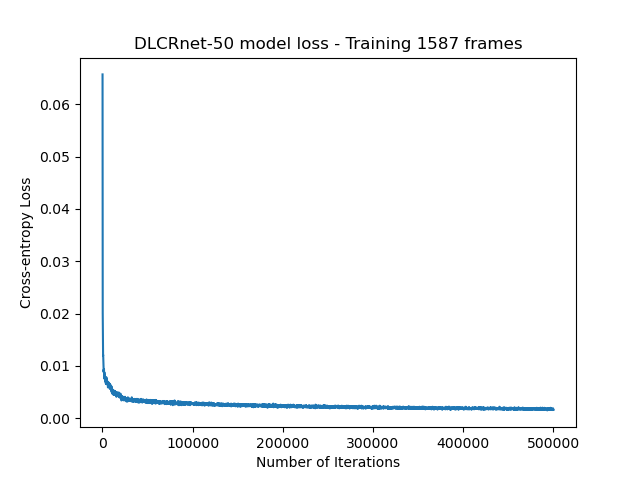

In [44]:
# Compute model's cross entropy loss
import pandas as pd
from IPython.display import display
import os
from matplotlib import pyplot as plt

# automatic way to get the folder without writing the path by hand
_, _, snapshotfolder = deeplabcut.return_train_network_path(
    config_path,
    shuffle=1,
    trainingsetindex=0,
)

stats = os.path.join(snapshotfolder, 'learning_stats.csv')
loss_df = pd.read_csv(stats, header=None)


x=[]
for i in loss_df[0]:
    colon_ind = i.find(':')
    itera=i[colon_ind+1:].strip()
    x.append(int(itera))

y= []
for l in loss_df[1]:
    colon_ind = l.find(':')
    loss=l[colon_ind+1:].strip()
    y.append(float(loss))
    
%matplotlib widget
plt.plot(x,y)
plt.ylabel('Cross-entropy Loss')
plt.xlabel('Number of Iterations')
plt.title('DLCRnet-50 model loss - Training 1587 frames')
plt.show()

# It may not seem that are many changes after the 20,000 iterations, but the truth is that when a video is predicted with 250,000 and 400,000 there is a huge difference in accuracy and precision.

### Evaluating the model and choosing the best snapshot

In [21]:
import os
import dlc2kinematics
import pandas as pd
import shutil
from IPython.display import display

D:/_users/Duarte_Projects/ma_new_DB_20_SingleView_DownCrop-Duarte-2022-09-13\snapshots_saved
D:\_users\Duarte_Projects\ma_new_DB_20_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_20_SingleView_DownCropSep13-trainset95shuffle1\train


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCropSep13\\ma_new_DB_20_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_500000  with # of trainingiterations: 500000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:16, 16.81it/s]


Results for 500000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.09 pixels. Test error: 3.04 pixels.
With pcutoff of 0.8:
Train error: 2.09 pixels. Test error: 3.02 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.138881
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           1.883118
elbow1         2.600545
elbow2         1.891500
finger1        1.954317
finger2        2.496927
robot_base     2.431300
robot_joint    1.942176
robot_logo     1.926869
robot_top      1.844231
shoulder1      2.471397
shoulder2      2.137084
wrist1         2.045193
wrist2         2.088108
Done and results stored for snapshot:  snapshot-500000
Selecting best skeleton...


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


1273it [00:00, 5025.25it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 38678.32it/s]


Graph 2|10


1273it [00:00, 5085.28it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47220.79it/s]


Graph 3|10


1273it [00:00, 5084.84it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45543.98it/s]


Graph 4|10


1273it [00:00, 5051.90it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49039.29it/s]


Graph 5|10


1273it [00:00, 5045.48it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 37518.61it/s]


Graph 6|10


1273it [00:00, 4966.05it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 42545.63it/s]


Graph 7|10


1273it [00:00, 5019.12it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 41192.96it/s]


Graph 8|10


1273it [00:00, 3743.14it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 51006.39it/s]


Graph 9|10


1273it [00:00, 5155.92it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 42523.94it/s]


Graph 10|10


1273it [00:00, 4971.04it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 37541.56it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCr

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_450000  with # of trainingiterations: 450000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:10, 18.05it/s]


Results for 450000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.04 pixels. Test error: 3.05 pixels.
With pcutoff of 0.8:
Train error: 2.04 pixels. Test error: 3.03 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.095125
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           2.054318
elbow1         2.306070
elbow2         1.950408
finger1        1.925889
finger2        2.661671
robot_base     2.403793
robot_joint    1.838190
robot_logo     1.954943
robot_top      1.727710
shoulder1      2.415591
shoulder2      2.159399
wrist1         2.069147
wrist2         1.801173
Done and results stored for snapshot:  snapshot-450000
Selecting best skeleton...


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


1273it [00:00, 5282.46it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49039.74it/s]


Graph 2|10


1273it [00:00, 5295.20it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 41174.53it/s]


Graph 3|10


1273it [00:00, 4574.97it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 43253.56it/s]


Graph 4|10


1273it [00:00, 5023.50it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47207.43it/s]


Graph 5|10


1273it [00:00, 5235.15it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 44013.72it/s]


Graph 6|10


1273it [00:00, 5146.41it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47220.79it/s]


Graph 7|10


1273it [00:00, 5274.02it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45543.98it/s]


Graph 8|10


1273it [00:00, 4935.83it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49100.17it/s]


Graph 9|10


1273it [00:00, 5263.33it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47273.89it/s]


Graph 10|10


1273it [00:00, 5231.48it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 41188.51it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCr

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_400000  with # of trainingiterations: 400000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:09, 18.44it/s]


Results for 400000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.04 pixels. Test error: 2.98 pixels.
With pcutoff of 0.8:
Train error: 2.04 pixels. Test error: 2.96 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.089442
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           1.956458
elbow1         2.308557
elbow2         1.749359
finger1        1.829774
finger2        2.595461
robot_base     2.332411
robot_joint    1.800892
robot_logo     2.019305
robot_top      2.022208
shoulder1      2.448823
shoulder2      2.127750
wrist1         1.891871
wrist2         1.937702
Done and results stored for snapshot:  snapshot-400000
Selecting best skeleton...


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


1273it [00:00, 5318.39it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45540.88it/s]


Graph 2|10


1273it [00:00, 5274.45it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 41130.13it/s]


Graph 3|10


1273it [00:00, 5231.34it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 51003.95it/s]


Graph 4|10


1273it [00:00, 5306.11it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47354.81it/s]


Graph 5|10


1273it [00:00, 5146.85it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 51005.42it/s]


Graph 6|10


1273it [00:00, 5251.46it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 48200.82it/s]


Graph 7|10


1273it [00:00, 5274.69it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47272.21it/s]


Graph 8|10


1273it [00:00, 5209.32it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49035.24it/s]


Graph 9|10


1273it [00:00, 5196.50it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49038.39it/s]


Graph 10|10


1273it [00:00, 5306.58it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49039.29it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCr

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_350000  with # of trainingiterations: 350000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:08, 18.66it/s]


Results for 350000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.15 pixels. Test error: 3.09 pixels.
With pcutoff of 0.8:
Train error: 2.15 pixels. Test error: 3.09 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.196918
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           2.049374
elbow1         2.442782
elbow2         2.059966
finger1        2.112495
finger2        2.626322
robot_base     2.245422
robot_joint    2.003161
robot_logo     2.030634
robot_top      1.949914
shoulder1      2.741452
shoulder2      2.319039
wrist1         2.042491
wrist2         1.999101
Done and results stored for snapshot:  snapshot-350000
Selecting best skeleton...


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


1273it [00:00, 4967.44it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 38674.40it/s]


Graph 2|10


1273it [00:00, 5024.68it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45558.75it/s]


Graph 3|10


1273it [00:00, 5024.71it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 44024.25it/s]


Graph 4|10


1273it [00:00, 5044.56it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45536.60it/s]


Graph 5|10


1273it [00:00, 5005.55it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 38649.20it/s]


Graph 6|10


1273it [00:00, 5004.96it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 36110.11it/s]


Graph 7|10


1273it [00:00, 4684.20it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45569.64it/s]


Graph 8|10


1273it [00:00, 4890.51it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 43972.40it/s]


Graph 9|10


1273it [00:00, 5033.84it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 44014.81it/s]


Graph 10|10


1273it [00:00, 4946.35it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 43972.40it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCr

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_300000  with # of trainingiterations: 300000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:08, 18.56it/s]


Results for 300000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.08 pixels. Test error: 3.04 pixels.
With pcutoff of 0.8:
Train error: 2.08 pixels. Test error: 3.02 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.131869
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           1.886736
elbow1         2.282864
elbow2         2.021880
finger1        2.021544
finger2        2.533080
robot_base     2.572200
robot_joint    1.813358
robot_logo     2.024263
robot_top      1.879698
shoulder1      2.501403
shoulder2      2.295165
wrist1         1.847549
wrist2         2.174767
Done and results stored for snapshot:  snapshot-300000
Selecting best skeleton...


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


1273it [00:00, 5321.02it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45539.71it/s]


Graph 2|10


1273it [00:00, 5362.51it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47225.38it/s]


Graph 3|10


1273it [00:00, 5317.77it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 44012.27it/s]


Graph 4|10


1273it [00:00, 5294.91it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49038.84it/s]


Graph 5|10


1273it [00:00, 5295.64it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 43993.05it/s]


Graph 6|10


1273it [00:00, 5318.17it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45621.03it/s]


Graph 7|10


1273it [00:00, 5280.90it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49041.09it/s]


Graph 8|10


1273it [00:00, 5320.05it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 41138.69it/s]


Graph 9|10


1273it [00:00, 2823.81it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 50994.70it/s]


Graph 10|10


1273it [00:00, 5273.44it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 46316.35it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCr

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_250000  with # of trainingiterations: 250000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:08, 18.69it/s]


Results for 250000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.06 pixels. Test error: 3.03 pixels.
With pcutoff of 0.8:
Train error: 2.06 pixels. Test error: 3.0 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.109131
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           1.804674
elbow1         2.193693
elbow2         2.167384
finger1        1.978738
finger2        2.301535
robot_base     2.339444
robot_joint    1.866767
robot_logo     1.973834
robot_top      2.118992
shoulder1      2.587838
shoulder2      2.324088
wrist1         1.970092
wrist2         1.904878
Done and results stored for snapshot:  snapshot-250000
Selecting best skeleton...


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


1273it [00:00, 5274.43it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 50994.70it/s]


Graph 2|10


1273it [00:00, 5197.80it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47320.81it/s]


Graph 3|10


1273it [00:00, 5296.19it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 48046.84it/s]


Graph 4|10


1273it [00:00, 5219.13it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45582.87it/s]


Graph 5|10


1273it [00:00, 5230.63it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 51062.00it/s]


Graph 6|10


1273it [00:00, 5305.07it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 44019.17it/s]


Graph 7|10


1273it [00:00, 4879.49it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47264.68it/s]


Graph 8|10


1273it [00:00, 2817.70it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49093.85it/s]


Graph 9|10


1273it [00:00, 5283.24it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47275.14it/s]


Graph 10|10


1273it [00:00, 5271.81it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45607.40it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCr

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_200000  with # of trainingiterations: 200000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:09, 18.47it/s]


Results for 200000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.11 pixels. Test error: 3.07 pixels.
With pcutoff of 0.8:
Train error: 2.11 pixels. Test error: 3.04 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.161115
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           1.997612
elbow1         2.326123
elbow2         2.207684
finger1        2.141747
finger2        2.394718
robot_base     2.256461
robot_joint    2.017415
robot_logo     2.155684
robot_top      1.981261
shoulder1      2.644148
shoulder2      2.197598
wrist1         1.908888
wrist2         1.904046
Done and results stored for snapshot:  snapshot-200000
Selecting best skeleton...
Graph 1|10


1273it [00:00, 5296.92it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47273.89it/s]


Graph 2|10


1273it [00:00, 5252.13it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 43974.21it/s]


Graph 3|10


1273it [00:00, 5230.52it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45530.00it/s]


Graph 4|10


1273it [00:00, 5274.43it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47229.14it/s]


Graph 5|10


1273it [00:00, 5273.84it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49044.25it/s]


Graph 6|10


1273it [00:00, 5296.36it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47273.89it/s]


Graph 7|10


1273it [00:00, 5262.10it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49093.85it/s]


Graph 8|10


1273it [00:00, 2855.32it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45589.09it/s]


Graph 9|10


1273it [00:00, 5274.42it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 46280.62it/s]


Graph 10|10


1273it [00:00, 5263.48it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49090.24it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_20_SingleView_DownCr

Running  DLC_dlcrnetms5_ma_new_DB_20_SingleView_DownCropSep13shuffle1_150000  with # of trainingiterations: 150000
Activating extracting of PAFs
Network Evaluation underway...


1278it [01:10, 18.08it/s]


Results for 150000 training iterations, training fraction of 95, and shuffle 1:
Train error: 2.12 pixels. Test error: 3.02 pixels.
With pcutoff of 0.8:
Train error: 2.12 pixels. Test error: 3.02 pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels)
individuals
participant    2.175101
Average Euclidean distance to GT per bodypart (in pixels)
bodyparts
chin           2.054012
elbow1         2.505631
elbow2         1.959144
finger1        2.092198
finger2        2.324571
robot_base     2.354882
robot_joint    1.929215
robot_logo     1.960713
robot_top      2.139480
shoulder1      2.793034
shoulder2      2.174905
wrist1         1.890764
wrist2         1.744018
Done and results stored for snapshot:  snapshot-150000
Selecting best skeleton...


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\deeplabcut\pose_estimation_tensorflow\lib\crossvalutils.py:83: RuntimeWarning: invalid value encountered in true_divide
  hist_left = hist_left / hist_left.sum()


Graph 1|10


1273it [00:00, 4947.33it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 47277.23it/s]


Graph 2|10


1273it [00:00, 5025.24it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 44025.70it/s]


Graph 3|10


1273it [00:00, 5230.80it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 42509.73it/s]


Graph 4|10


1273it [00:00, 5273.72it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 49041.99it/s]


Graph 5|10


1273it [00:00, 5296.30it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 42510.40it/s]


Graph 6|10


1273it [00:00, 2771.56it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45540.88it/s]


Graph 7|10


1273it [00:00, 5252.74it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 34510.20it/s]


Graph 8|10


1273it [00:00, 4789.44it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 37542.09it/s]


Graph 9|10


1273it [00:00, 4089.26it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 30390.74it/s]


Graph 10|10


1273it [00:00, 5084.63it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 45583.26it/s]


Unnamed: 0  Training iterations:  %Training dataset  Shuffle number  \
0           0                150000                 95               1   
1           1                200000                 95               1   
2           2                250000                 95               1   
3           3                300000                 95               1   
4           4                350000                 95               1   
5           5                400000                 95               1   
6           6                450000                 95               1   
7           7                500000                 95               1   

    Train error(px)   Test error(px)  p-cutoff used  \
0              2.12             3.02            0.8   
1              2.11             3.07            0.8   
2              2.06             3.03            0.8   
3              2.08             3.04            0.8   
4              2.15             3.09            0.8   
5              2.04             2.98            0.8   
6              2.04             3.05            0.8   
7              2.09             3.04            0.8   

   Train error with p-cutoff  Test error with p-cutoff  
0                       2.12                      3.02  
1                       2.11                      3.04  
2                       2.06                      3.00  
3                       2.08                      3.02  
4                       2.15                      3.09  
5                       2.04                      2.96  
6                       2.04                      3.03  
7                       2.09                      3.02

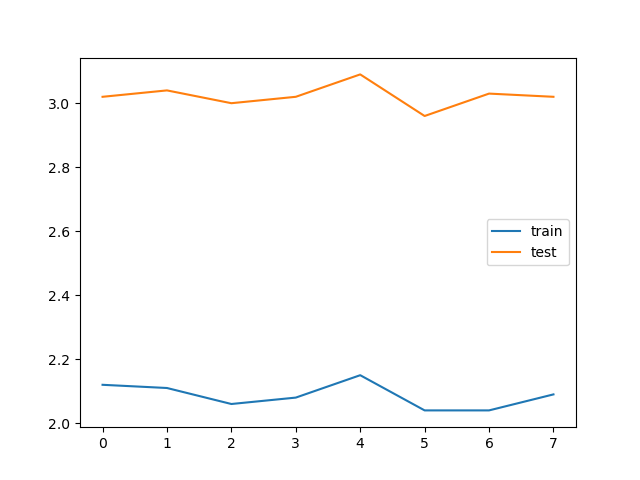

In [22]:
#DO THIS IN CASE YOU EVALUATE DIFFERENT SNAPSHOT MODELS - INTERESTING FOR 500K ITER

from matplotlib import pyplot as plt

# create new directory to store the snapshots
snap_save=os.path.dirname(config_path) + r'\snapshots_saved'
print(snap_save)
os.mkdir(snap_save)

_, _, snapshotfolder = deeplabcut.return_train_network_path(
    config_path,
    shuffle=1,
    trainingsetindex=0,
)
print(snapshotfolder)
iterations = ['500000','450000','400000','350000','300000','250000','200000','150000']
snap_keep = 8 # must be the same has the length of iterations list

for i in range(snap_keep):
    deeplabcut.evaluate_network(config_path,Shuffles=[1], plotting=False, gputouse=0)
    for root, dirs, files in os.walk(snapshotfolder):
        for filename in files:
            if iterations[i] in filename:
                # the evaluate_network function always uses the snapshot with highest number of iterations! So, they need to be moved automatically moved to another folder so that the function evaluates using the next lowest iteration 
                shutil.move(root+'/'+filename,snap_save)

# after evaluating the training frames with all the snapshots, the results are summarized in the file below
combined_path = os.path.dirname(config_path) + r'\evaluation-results\iteration-0\CombinedEvaluation-results.csv'                
df = pd.read_csv(combined_path)
display(df)

train_err = list(df['Train error with p-cutoff'])
test_err = list(df['Test error with p-cutoff'])


ind = range(snap_keep)
%matplotlib widget
# plot lines
plt.plot(ind, train_err , label = "train")
plt.plot(ind, test_err, label = "test")
plt.legend()
plt.show()

# to read this plot, only iterations above 300,000 matter! Check which one has the lowest test_error (ideally it should also match with the lowest train error)
# the train and test appear because the images labeled are divided into a 95% train & 5% test to evaluate the model

In [ ]:
''' After running the previous cell once, you don't need to evaluate everything again! Just run this one, and the plot will appear based on the .csv.'''
combined_path = os.path.dirname(config_path) + r'\evaluation-results\iteration-0\CombinedEvaluation-results.csv'                
df = pd.read_csv(combined_path)

train_err = list(df['Train error with p-cutoff'])
test_err = list(df['Test error with p-cutoff'])
itera = list(df['Training iterations:'])
ind = range(snap_keep)
%matplotlib widget
# plot lines
plt.plot(itera, train_err , label = "train")
plt.plot(itera, test_err, label = "test")
plt.legend()
plt.title('Model Evaluation')
plt.xlabel('Iteration snapshots saved')
plt.ylabel('RMSE (pixels)')
plt.show()

In [ ]:
# CHECK THE RMSE FOR THE GROUNDTRUTH LABELS VS THE PREDICTIONS
#not sure if this cell works properly
from matplotlib import pyplot as plt
import pandas as pd

combined_path = r"D:\_users\Duarte_Projects\ma_LL_Final_Crop-Duarte-2022-06-02\evaluation-results\iteration-0\ma_LL_Final_CropJun2-trainset95shuffle1\dist_200000.csv"
df = pd.read_csv(combined_path)


train_err = list(df['Duarte'][3:10])
sortrain = sorted(train_err) # CORRECT THE INDEXES!!!!
test_err = list(df['Duarte.14'][3:])

print(sortrain)
ind = range(7)
%matplotlib widget
# plot lines
plt.plot(ind, sortrain , label = "chin")
# plt.plot(ind, test_err, label = "logo")
plt.legend()
plt.show()

### Full database analysis

In [62]:
''' Select a folder with all the videos you want to have completely analyzed. This can be the entire database of videos. 
Start by 2 or 3 videos that have good lighting and postion setup to see if the model works properly.
For the analysis and prediction process to be faster these videos should at least be downsampled to the 512x288 size. preferably also cropped.

In the end, it will create a directory per video in the project.

NOTE: When you run this cell, a new window opens to select the database folder with all the results. The new window
usually opens behind the code editor software.
'''
import os
from tkinter import Tk  
from tkinter.filedialog import askdirectory

Tk().withdraw()
# the name of the variable is Left_L because that was the first ever model created and it just stuck here
left_L = askdirectory(title='Select the folder with the videos you want to analyze', initialdir=r'\\svfas5.epfl.ch\blanke-lab\Users\Duarte\Data\Old_recordings')

# iterates through the directory and collects the paths of all the videos
videos_test=[]
for root, dirs, files in os.walk(left_L):
    for filename in files:
        # print(os.path.join(root, filename) + '    ' + filename[-3:])
        if (filename[-3:] == 'MP4' or filename[-3:] == 'mp4' or filename[-3:] == 'avi' or filename[-3:] == 'MOV' or filename[-3:] == 'mov') :
            if '7-30' in filename: # only participant that uses left hand
                if 'right_angle' not in filename and 'delay' not in filename: # important for the study 2
                    videoname=os.path.join(root, filename)
                    videos_test.append(videoname)
            elif 'left_angle' not in filename and 'delay' not in filename: # important for the study 2
                videoname=os.path.join(root, filename)
                videos_test.append(videoname)
print(videos_test)

['D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-14\\HC_7-14_R_async_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-14\\HC_7-14_R_sync_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-15\\HC_7-15_R_async_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-15\\HC_7-15_R_sync_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-16\\HC_7-16_R_async_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-16\\HC_7-16_R_sync_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-19\\HC_7-19_R_async_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/new_DB_Conditions_Downcrop\\HEALTHY_CONTROLS\\7-19\\HC_7-19_R_sync_right_angle_DownCrop.mp4', 'D:/_users/Duarte_Projects/

In [63]:
for vid in videos_test:
    file_mp4 = os.path.basename(vid)
    filename = file_mp4[:-13] # this minus value depends if the videos are just downsampled or also downcropped
    print(filename)
print(len(videos_test))

HC_7-14_R_async_right_angle
HC_7-14_R_sync_right_angle
HC_7-15_R_async_right_angle
HC_7-15_R_sync_right_angle
HC_7-16_R_async_right_angle
HC_7-16_R_sync_right_angle
HC_7-19_R_async_right_angle
HC_7-19_R_sync_right_angle
HC_7-25_R_async_right_angle
HC_7-25_R_sync_right_angle
HC_7-26_R_async_right_angle
HC_7-26_R_sync_right_angle
HC_7-28_R_async_right_angle
HC_7-28_R_sync_right_angle
HC_7-33_R_async_right_angle
HC_7-33_R_sync_right_angle
PD_7-1_R_async_right_angle
PD_7-1_R_sync_right_angle
PD_7-10_R_async_right_angle
PD_7-10_R_sync_right_angle
PD_7-11_R_async_right_angle
PD_7-11_R_async_right_angle_lat
PD_7-11_R_sync_right_angle
PD_7-11_R_sync_right_angle_lat
PD_7-12_R_async_right_angle
PD_7-12_R_sync_right_angle
HC_7-17_R_async_right_angle
HC_7-17_R_sync_right_angle
PD_7-2_R_async_right_angle
PD_7-2_R_sync_right_angle
PD_7-20_R_async_right_angle
PD_7-20_R_sync_right_angle
PD_7-21_R_async_right_angle
PD_7-21_R_sync_right_angle
PD_7-23_R_async_right_angle
PD_7-23_R_sync_right_angle
PD_7-2

In [65]:
''' In the videos folder of the projec, it creates a "project_results" folder. Inside this one, each video will have its own
folder with the prediction data (.h5) and video auto-labeled with those predictions.

To iterate through the entire database it can take entire days of computing. Depending on how many cores the PC has the
computer may become super slow.

Sometimes DLC breaks or the videos have problems or the windows path handling stops working; so there is a list that collects 
all the videos that failed! Sometimes, running this cell again may solve the issue. If the number of fails is not going down after 
running this cell a couple of times, then go by hand verify what seems to be the problem with those videos.'''

import os
fail = []
fnf = False

# creates the results folder
videos_folder=os.path.join(os.path.dirname(config_path),'videos')
res_folder=os.path.join(videos_folder,'Project_Results')
if not os.path.isdir(res_folder): 
    os.mkdir(res_folder)

for vid in videos_test:
    file_mp4 = os.path.basename(vid)
    filename = file_mp4[:-13] #ALWAYS VERIFY THIS LINE -> #-13 for downcrop | -15 for downsampling
    if filename[-2:] == 'do':
        filename = filename[:-2]
    destiny=os.path.join(res_folder,filename) #This destiny folder prevents from creating files in the videos directory in the project folder! makes things more organized
    
    # checks if a destiny  folder already exists! if it does, then that video was already analyzed
    if not os.path.isdir(destiny): 
        os.mkdir(destiny)
        
        # There are a couple of issues that can be faced when analysing the videos. This exception flags are created to prevent the entireprocess from breaking donw when one of those issues happens
        try:
            try:

                vid = vid.replace('/','\\')
                print(vid)
                scorername = deeplabcut.analyze_videos(config_path,vid, videotype='.mp4', batchsize=1, destfolder = destiny) #first analayis
                print('Starting to label the video...')
                deeplabcut.create_video_with_all_detections(config_path, vid, videotype='.mp4', destfolder = destiny) # creates auto-labeled video with the predictions
                print('New labeled video successfully created!')
                deeplabcut.plot_trajectories(config_path, vid, destfolder=destiny)# creates plots to help verify the efficacy (in accuracy and precision) of the predictions
                
                
                # The filter from DLC does not give good results usually! If you want to try uncomment the following blocks!
                # WARNING: In the All_DB analysis a personalized data cleaning and filtering method was developed. For it to work the functions below should not be run!!
                
                # deeplabcut.filterpredictions(config_path,vid,shuffle=1, filtertype='arima',ARdegree=5,MAdegree=2,destfolder = destiny)
                # deeplabcut.create_labeled_video(config_path,vid, save_frames=True, destfolder=destiny, draw_skeleton = True,filtered = True)
                # deeplabcut.plot_trajectories(config_path, vid, destfolder=destiny,filtered=True)
    
                # sometimes due to black magic, none of the previous functions work, so no data file or video is created
                if len(os.listdir(destiny)) == 0:
                    print('****************************The folder was REMOVED because no file was created!******************************')
                    fail.append(os.path.basename(destiny)) # registers which videos failed
                    os.rmdir(destiny)
                    
            except FileNotFoundError:
                print('=================== HERE:The video '+ vid +' is not found or accessed.===============================')
                fail.append(os.path.basename(destiny))  # registers which videos failed
                os.rmdir(destiny)
                fnf = True #file not found -> verify why
                
        except IndexError:
            fail.append(os.path.basename(destiny)) # the video has some problem and needs to be removed from the database
            if len(os.listdir(destiny)) == 0:
                os.rmdir(destiny)
            print('=================== HERE:The video '+ vid +' is not correctly encoded.===============================')
        

Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  123.82 , recorded with  59.98 fps!
Overall # of frames:  7427  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7427/7427 [04:28<00:00, 27.71it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-14_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-14_R_async_right_angle\HC_7-14_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7427it [00:01, 4959.33it/s]
7427it [00:00, 1060896.22it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  HC_7-14_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7427/7427 [00:19<00:00, 388.82it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  119.82 , recorded with  60.0 fps!
Overall # of frames:  7189  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7189/7189 [04:06<00:00, 29.20it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-14_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-14_R_sync_right_angle\HC_7-14_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7189it [00:01, 4981.04it/s]
7189it [00:00, 798370.35it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-14_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7189/7189 [00:18<00:00, 386.46it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-14\HC_7-14_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  77.96 , recorded with  59.97 fps!
Overall # of frames:  4675  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 4675/4675 [02:38<00:00, 29.41it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-15_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-15_R_async_right_angle\HC_7-15_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


4675it [00:00, 5269.53it/s]
4675it [00:00, 1163218.32it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-15_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 4675/4675 [00:12<00:00, 386.53it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  123.09 , recorded with  59.99 fps!
Overall # of frames:  7384  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7384/7384 [04:13<00:00, 29.14it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-15_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-15_R_sync_right_angle\HC_7-15_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7384it [00:01, 5009.56it/s]
7384it [00:00, 1052817.78it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_sync_right_angle_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-15_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7384/7384 [00:19<00:00, 384.32it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-15\HC_7-15_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  121.74 , recorded with  59.98 fps!
Overall # of frames:  7302  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7302/7302 [04:09<00:00, 29.31it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-16_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-16_R_async_right_angle\HC_7-16_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7302it [00:01, 5051.50it/s]
7302it [00:00, 1034409.88it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-16_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7302/7302 [00:19<00:00, 383.89it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  126.08 , recorded with  60.0 fps!
Overall # of frames:  7565  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7565/7565 [04:18<00:00, 29.21it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-16_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-16_R_sync_right_angle\HC_7-16_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7565it [00:01, 5216.71it/s]
7565it [00:00, 1082858.16it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-16_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7565/7565 [00:18<00:00, 399.00it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-16\HC_7-16_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  126.48 , recorded with  60.0 fps!
Overall # of frames:  7589  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7589/7589 [04:17<00:00, 29.47it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-19_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-19_R_async_right_angle\HC_7-19_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7589it [00:01, 5278.68it/s]
7589it [00:00, 1086145.26it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  HC_7-19_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7589/7589 [00:19<00:00, 396.41it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  124.35 , recorded with  60.0 fps!
Overall # of frames:  7461  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7461/7461 [04:16<00:00, 29.14it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-19_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-19_R_sync_right_angle\HC_7-19_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7461it [00:01, 4998.43it/s]
7461it [00:00, 1064991.22it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-19_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7461/7461 [00:19<00:00, 379.16it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-19\HC_7-19_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  129.75 , recorded with  59.99 fps!
Overall # of frames:  7784  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7784/7784 [04:24<00:00, 29.46it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-25_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-25_R_async_right_angle\HC_7-25_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7784it [00:01, 5193.80it/s]
7784it [00:00, 975017.54it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-25_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7784/7784 [00:19<00:00, 399.61it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  128.36 , recorded with  59.98 fps!
Overall # of frames:  7699  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7699/7699 [04:20<00:00, 29.59it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-25_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-25_R_sync_right_angle\HC_7-25_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7699it [00:01, 5207.48it/s]
7699it [00:00, 964889.19it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-25_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7699/7699 [00:19<00:00, 399.79it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-25\HC_7-25_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  94.36 , recorded with  59.98 fps!
Overall # of frames:  5660  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 5660/5660 [03:12<00:00, 29.39it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-26_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-26_R_async_right_angle\HC_7-26_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


5660it [00:00, 5683.24it/s]
5660it [00:00, 1024634.67it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-26_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 5660/5660 [00:12<00:00, 465.56it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  105.85 , recorded with  59.98 fps!
Overall # of frames:  6349  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 6349/6349 [03:35<00:00, 29.45it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-26_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-26_R_sync_right_angle\HC_7-26_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


6349it [00:01, 5419.46it/s]
6349it [00:00, 1063653.78it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  HC_7-26_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 6349/6349 [00:14<00:00, 449.44it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-26\HC_7-26_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  129.32 , recorded with  60.0 fps!
Overall # of frames:  7759  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7759/7759 [04:27<00:00, 28.97it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-28_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-28_R_async_right_angle\HC_7-28_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7759it [00:01, 5206.04it/s]
7759it [00:00, 1108206.93it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-28_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7759/7759 [00:18<00:00, 419.98it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  130.07 , recorded with  59.99 fps!
Overall # of frames:  7803  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7803/7803 [04:25<00:00, 29.37it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-28_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-28_R_sync_right_angle\HC_7-28_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7803it [00:01, 5171.60it/s]
7803it [00:00, 974110.19it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-28_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7803/7803 [00:18<00:00, 412.17it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-28\HC_7-28_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  106.27 , recorded with  59.99 fps!
Overall # of frames:  6375  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 6375/6375 [03:52<00:00, 27.38it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-33_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-33_R_async_right_angle\HC_7-33_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


6375it [00:01, 4518.99it/s]
6375it [00:00, 913300.13it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  HC_7-33_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 6375/6375 [00:17<00:00, 363.08it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  122.18 , recorded with  60.0 fps!
Overall # of frames:  7331  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


 33%|█████████████████████████▉                                                    | 2432/7331 [01:28<02:57, 27.59it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_Single

=================== HERE:The video D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\HEALTHY_CONTROLS\7-33\HC_7-33_R_sync_right_angle_DownCrop.mp4 is not correctly encoded.===============================
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  131.23 , recorded with  59.98 fps!
Overall # of frames:  7871  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7871/7871 [04:26<00:00, 29.51it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-1_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-1_R_async_right_angle\PD_7-1_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7871it [00:01, 5348.20it/s]
7871it [00:00, 983272.28it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-1_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7871/7871 [00:18<00:00, 416.30it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  136.15 , recorded with  60.0 fps!
Overall # of frames:  8169  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 8169/8169 [04:37<00:00, 29.48it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-1_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-1_R_sync_right_angle\PD_7-1_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


8169it [00:01, 5389.32it/s]
8169it [00:00, 1019558.10it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-1_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 8169/8169 [00:19<00:00, 420.06it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-1\PD_7-1_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  124.04 , recorded with  25.0 fps!
Overall # of frames:  3101  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3101/3101 [01:45<00:00, 29.30it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-10_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-10_R_async_right_angle\PD_7-10_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3101it [00:00, 5464.52it/s]
3101it [00:00, 1038694.83it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-10_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3101/3101 [00:07<00:00, 436.94it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  126.44 , recorded with  25.0 fps!
Overall # of frames:  3161  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3161/3161 [01:48<00:00, 29.18it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-10_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-10_R_sync_right_angle\PD_7-10_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3161it [00:00, 4164.87it/s]
3161it [00:00, 792385.55it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-10_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3161/3161 [00:07<00:00, 429.43it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-10\PD_7-10_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  123.48 , recorded with  60.0 fps!
Overall # of frames:  7409  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7409/7409 [04:11<00:00, 29.42it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_async_right_angle\PD_7-11_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7409it [00:01, 5053.70it/s]
7409it [00:00, 1057856.70it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-11_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7409/7409 [00:19<00:00, 383.87it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_lat_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_lat_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_lat_DownCrop.mp4
Duration of video [s]:  122.92 , recorded with  50.0 fps!
Overall # of frames:  6146  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 6146/6146 [03:35<00:00, 28.57it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_async_right_angle_lat...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_lat_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_async_right_angle_lat\PD_7-11_R_async_right_angle_lat_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


6146it [00:01, 4113.33it/s]
6146it [00:00, 616201.95it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_lat_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-11_R_async_right_angle_lat_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 6146/6146 [00:14<00:00, 423.64it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_async_right_angle_lat_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  121.35 , recorded with  60.0 fps!
Overall # of frames:  7281  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7281/7281 [04:16<00:00, 28.40it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_sync_right_angle\PD_7-11_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7281it [00:01, 4858.17it/s]
7281it [00:00, 1038449.65it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-11_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7281/7281 [00:20<00:00, 361.60it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_lat_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_lat_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_lat_DownCrop.mp4
Duration of video [s]:  118.46 , recorded with  50.0 fps!
Overall # of frames:  5923  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 5923/5923 [03:22<00:00, 29.27it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_sync_right_angle_lat...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_lat_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-11_R_sync_right_angle_lat\PD_7-11_R_sync_right_angle_lat_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


5923it [00:01, 5090.87it/s]
5923it [00:00, 593815.44it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_lat_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-11_R_sync_right_angle_lat_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 5923/5923 [00:13<00:00, 447.80it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-11\PD_7-11_R_sync_right_angle_lat_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  125.75 , recorded with  59.99 fps!
Overall # of frames:  7544  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7544/7544 [04:24<00:00, 28.57it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-12_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-12_R_async_right_angle\PD_7-12_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7544it [00:01, 4020.96it/s]
7544it [00:00, 948353.95it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-12_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7544/7544 [00:18<00:00, 409.23it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  127.23 , recorded with  59.98 fps!
Overall # of frames:  7631  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7631/7631 [04:24<00:00, 28.82it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-12_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-12_R_sync_right_angle\PD_7-12_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7631it [00:01, 5141.28it/s]
7631it [00:00, 952638.07it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-12_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7631/7631 [00:19<00:00, 383.24it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-12\PD_7-12_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  129.08 , recorded with  59.98 fps!
Overall # of frames:  7742  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [04:31<00:00, 28.49it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-17_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-17_R_async_right_angle\HC_7-17_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7742it [00:01, 5012.96it/s]
7742it [00:00, 863739.90it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-17_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7742/7742 [00:22<00:00, 349.51it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  124.21 , recorded with  59.98 fps!
Overall # of frames:  7450  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7450/7450 [04:20<00:00, 28.56it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-17_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\HC_7-17_R_sync_right_angle\HC_7-17_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7450it [00:01, 4721.98it/s]
7450it [00:00, 933515.51it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_sync_right_angle_DownCrop.mp4


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  HC_7-17_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7450/7450 [00:21<00:00, 345.44it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-17\HC_7-17_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  121.9 , recorded with  24.98 fps!
Overall # of frames:  3045  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3045/3045 [01:48<00:00, 28.01it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-2_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-2_R_async_right_angle\PD_7-2_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3045it [00:00, 4303.02it/s]
3045it [00:00, 1018067.41it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-2_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3045/3045 [00:07<00:00, 397.97it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  100.16 , recorded with  25.0 fps!
Overall # of frames:  2504  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2504/2504 [01:28<00:00, 28.40it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-2_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-2_R_sync_right_angle\PD_7-2_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


2504it [00:00, 5246.93it/s]
2504it [00:00, 1262779.51it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-2_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 2504/2504 [00:06<00:00, 395.16it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-2\PD_7-2_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  129.48 , recorded with  59.98 fps!
Overall # of frames:  7766  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7766/7766 [04:30<00:00, 28.69it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-20_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-20_R_async_right_angle\PD_7-20_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7766it [00:01, 4971.05it/s]
7766it [00:00, 969289.24it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-20_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7766/7766 [00:22<00:00, 352.28it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  130.89 , recorded with  59.98 fps!
Overall # of frames:  7851  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7851/7851 [04:35<00:00, 28.47it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-20_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-20_R_sync_right_angle\PD_7-20_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7851it [00:01, 4995.25it/s]
7851it [00:00, 984085.85it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-20_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7851/7851 [00:21<00:00, 363.92it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-20\PD_7-20_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  128.82 , recorded with  59.99 fps!
Overall # of frames:  7728  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7728/7728 [04:32<00:00, 28.36it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-21_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-21_R_async_right_angle\PD_7-21_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7728it [00:01, 4963.61it/s]
7728it [00:00, 968118.67it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-21_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7728/7728 [00:21<00:00, 364.26it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  128.01 , recorded with  59.98 fps!
Overall # of frames:  7678  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7678/7678 [04:28<00:00, 28.60it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-21_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-21_R_sync_right_angle\PD_7-21_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7678it [00:01, 5030.38it/s]
7678it [00:00, 958476.92it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-21_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7678/7678 [00:19<00:00, 400.02it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-21\PD_7-21_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  128.28 , recorded with  59.98 fps!
Overall # of frames:  7694  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7694/7694 [04:23<00:00, 29.19it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-23_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-23_R_async_right_angle\PD_7-23_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7694it [00:01, 5149.39it/s]
7694it [00:00, 1098661.18it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-23_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7694/7694 [00:19<00:00, 400.77it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  126.88 , recorded with  59.98 fps!
Overall # of frames:  7610  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7610/7610 [04:21<00:00, 29.06it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-23_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-23_R_sync_right_angle\PD_7-23_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7610it [00:01, 5188.45it/s]
7610it [00:00, 1085151.75it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_sync_right_angle_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-23_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7610/7610 [00:19<00:00, 397.17it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-23\PD_7-23_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  127.94 , recorded with  59.98 fps!
Overall # of frames:  7674  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7674/7674 [04:24<00:00, 29.04it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-27_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-27_R_async_right_angle\PD_7-27_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7674it [00:01, 5513.01it/s]
7674it [00:00, 1100714.35it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-27_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7674/7674 [00:18<00:00, 418.19it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  127.48 , recorded with  59.98 fps!
Overall # of frames:  7646  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7646/7646 [04:21<00:00, 29.24it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-27_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-27_R_sync_right_angle\PD_7-27_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7646it [00:01, 5146.14it/s]
7646it [00:00, 1090062.83it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-27_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7646/7646 [00:19<00:00, 393.94it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-27\PD_7-27_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  128.55 , recorded with  59.99 fps!
Overall # of frames:  7712  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7712/7712 [04:25<00:00, 29.10it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-29_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-29_R_async_right_angle\PD_7-29_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7712it [00:01, 5363.58it/s]
7712it [00:00, 1281708.30it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_async_right_angle_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-29_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7712/7712 [00:17<00:00, 432.33it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  130.49 , recorded with  59.99 fps!
Overall # of frames:  7828  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7828/7828 [04:26<00:00, 29.41it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-29_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-29_R_sync_right_angle\PD_7-29_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7828it [00:01, 5383.12it/s]
7828it [00:00, 1115403.31it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_sync_right_angle_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-29_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7828/7828 [00:18<00:00, 430.93it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-29\PD_7-29_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_async_left_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_async_left_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_async_left_angle_DownCrop.mp4
Duration of video [s]:  142.89 , recorded with  59.99 fps!
Overall # of frames:  8572  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 8572/8572 [04:55<00:00, 28.99it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-30_L_async_left_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_async_left_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-30_L_async_left_angle\PD_7-30_L_async_left_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


8572it [00:01, 5122.58it/s]
8572it [00:00, 1074395.59it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_async_left_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-30_L_async_left_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 8572/8572 [00:19<00:00, 430.92it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_async_left_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_sync_left_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_sync_left_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_sync_left_angle_DownCrop.mp4
Duration of video [s]:  121.33 , recorded with  60.0 fps!
Overall # of frames:  7280  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7280/7280 [04:08<00:00, 29.35it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-30_L_sync_left_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_sync_left_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-30_L_sync_left_angle\PD_7-30_L_sync_left_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7280it [00:01, 5431.36it/s]
7280it [00:00, 1042205.38it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_sync_left_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-30_L_sync_left_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7280/7280 [00:15<00:00, 470.99it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-30\PD_7-30_L_sync_left_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  125.89 , recorded with  59.98 fps!
Overall # of frames:  7551  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7551/7551 [04:15<00:00, 29.51it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-31_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-31_R_async_right_angle\PD_7-31_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7551it [00:01, 5647.44it/s]
7551it [00:00, 1076628.80it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-31_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7551/7551 [00:16<00:00, 449.57it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  128.65 , recorded with  59.99 fps!
Overall # of frames:  7718  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7718/7718 [04:25<00:00, 29.08it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-31_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-31_R_sync_right_angle\PD_7-31_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7718it [00:01, 5343.60it/s]
7718it [00:00, 1102538.68it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-31_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7718/7718 [00:17<00:00, 438.64it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-31\PD_7-31_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  139.74 , recorded with  59.99 fps!
Overall # of frames:  8383  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 8383/8383 [04:45<00:00, 29.38it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-34_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-34_R_async_right_angle\PD_7-34_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


8383it [00:01, 5632.73it/s]
8383it [00:00, 1046547.32it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_async_right_angle_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-34_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 8383/8383 [00:18<00:00, 465.68it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  127.63 , recorded with  59.98 fps!
Overall # of frames:  7655  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7655/7655 [04:24<00:00, 28.97it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-34_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-34_R_sync_right_angle\PD_7-34_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7655it [00:01, 5633.15it/s]
7655it [00:00, 1091679.89it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-34_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7655/7655 [00:16<00:00, 463.74it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-34\PD_7-34_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  143.23 , recorded with  60.0 fps!
Overall # of frames:  8594  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 8594/8594 [04:52<00:00, 29.34it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-35_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-35_R_async_right_angle\PD_7-35_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


8594it [00:01, 5605.74it/s]
8594it [00:00, 1076992.10it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-35_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 8594/8594 [00:18<00:00, 462.93it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  134.3 , recorded with  60.0 fps!
Overall # of frames:  8058  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 8058/8058 [04:36<00:00, 29.12it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-35_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-35_R_sync_right_angle\PD_7-35_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


8058it [00:01, 5605.53it/s]
8058it [00:00, 1005854.04it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_sync_right_angle_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-35_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 8058/8058 [00:17<00:00, 461.18it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-35\PD_7-35_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  134.71 , recorded with  59.99 fps!
Overall # of frames:  8081  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 8081/8081 [04:39<00:00, 28.94it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-39_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-39_R_async_right_angle\PD_7-39_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


8081it [00:01, 5013.87it/s]
8081it [00:00, 1008184.97it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-39_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 8081/8081 [00:19<00:00, 404.33it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  121.79 , recorded with  59.98 fps!
Overall # of frames:  7305  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7305/7305 [04:10<00:00, 29.13it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-39_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-39_R_sync_right_angle\PD_7-39_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7305it [00:01, 5127.06it/s]
7305it [00:00, 1048073.84it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_sync_right_angle_DownCrop.mp4


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 995.33it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-39_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:18<00:00, 404.13it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-39\PD_7-39_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  124.04 , recorded with  25.0 fps!
Overall # of frames:  3101  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3101/3101 [01:47<00:00, 28.96it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-4_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-4_R_async_right_angle\PD_7-4_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3101it [00:00, 5391.86it/s]
3101it [00:00, 1025509.48it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_async_right_angle_DownCrop.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1016.31it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-4_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3101/3101 [00:07<00:00, 408.10it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  124.53 , recorded with  24.99 fps!
Overall # of frames:  3112  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3112/3112 [01:46<00:00, 29.33it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-4_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-4_R_sync_right_angle\PD_7-4_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3112it [00:00, 5522.59it/s]
3112it [00:00, 623843.33it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


Starting to label the video...
Creating labeled video for  PD_7-4_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3112/3112 [00:07<00:00, 418.61it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-4\PD_7-4_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  104.25 , recorded with  59.97 fps!
Overall # of frames:  6252  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 6252/6252 [03:34<00:00, 29.10it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-40_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-40_R_async_right_angle\PD_7-40_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


6252it [00:01, 5374.07it/s]
6252it [00:00, 1039349.53it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-40_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 6252/6252 [00:14<00:00, 429.97it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  129.51 , recorded with  59.98 fps!
Overall # of frames:  7768  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 7768/7768 [04:25<00:00, 29.23it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-40_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-40_R_sync_right_angle\PD_7-40_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


7768it [00:01, 5184.34it/s]
7768it [00:00, 969510.01it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-40_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 7768/7768 [00:19<00:00, 390.50it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-40\PD_7-40_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  124.9 , recorded with  24.98 fps!
Overall # of frames:  3120  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3120/3120 [01:47<00:00, 29.06it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-5_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-5_R_async_right_angle\PD_7-5_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3120it [00:00, 5407.89it/s]
3120it [00:00, 1042312.11it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-5_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3120/3120 [00:07<00:00, 405.32it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  127.77 , recorded with  24.99 fps!
Overall # of frames:  3193  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3193/3193 [01:49<00:00, 29.21it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-5_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-5_R_sync_right_angle\PD_7-5_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3193it [00:00, 5519.70it/s]
3193it [00:00, 1600049.30it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-5_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3193/3193 [00:07<00:00, 407.36it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-5\PD_7-5_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  121.2 , recorded with  25.0 fps!
Overall # of frames:  3030  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3030/3030 [01:43<00:00, 29.24it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-6_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-6_R_async_right_angle\PD_7-6_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3030it [00:00, 5622.16it/s]
3030it [00:00, 1002029.58it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-6_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3030/3030 [00:06<00:00, 444.33it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  59.16 , recorded with  25.0 fps!
Overall # of frames:  1479  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:51<00:00, 28.92it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-6_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-6_R_sync_right_angle\PD_7-6_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


1479it [00:00, 4752.83it/s]
1479it [00:00, 741232.60it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...
Creating labeled video for  PD_7-6_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:03<00:00, 407.80it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-6\PD_7-6_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  121.28 , recorded with  25.0 fps!
Overall # of frames:  3032  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3032/3032 [01:42<00:00, 29.44it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-7_R_async_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_async_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-7_R_async_right_angle\PD_7-7_R_async_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3032it [00:01, 2722.54it/s]
3032it [00:00, 1014610.64it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_async_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-7_R_async_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3032/3032 [00:06<00:00, 472.13it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_async_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  126.4 , recorded with  25.0 fps!
Overall # of frames:  3160  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3160/3160 [01:48<00:00, 29.23it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-7_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-7_R_sync_right_angle\PD_7-7_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3160it [00:00, 5844.81it/s]
3160it [00:00, 1045020.94it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-7_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3160/3160 [00:06<00:00, 473.39it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-7\PD_7-7_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  124.32 , recorded with  25.0 fps!
Overall # of frames:  3108  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


 62%|████████████████████████████████████████████████▎                             | 1926/3108 [01:05<00:40, 29.43it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_Single

=================== HERE:The video D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_async_right_angle_DownCrop.mp4 is not correctly encoded.===============================
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  124.8 , recorded with  25.0 fps!
Overall # of frames:  3120  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


100%|██████████████████████████████████████████████████████████████████████████████| 3120/3120 [01:46<00:00, 29.26it/s]


Video Analyzed. Saving results in D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-8_R_sync_right_angle...


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_sync_right_angle_DownCrop.mp4
Analyzing D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\videos\Singleview_10_Results\PD_7-8_R_sync_right_angle\PD_7-8_R_sync_right_angle_DownCropDLC_dlcrnetms5_ma_new_DB_10_SingleView_DownCropSep13shuffle1_350000.h5


3120it [00:00, 6060.32it/s]
3120it [00:00, 776400.38it/s]


The tracklets were created (i.e., under the hood deeplabcut.convert_detections2tracklets was run). Now you can 'refine_tracklets' in the GUI, or run 'deeplabcut.stitch_tracklets'.
Processing...  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_sync_right_angle_DownCrop.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

The videos are analyzed. Time to assemble animals and track 'em... 
 Call 'create_video_with_all_detections' to check multi-animal detection quality before tracking.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Starting to label the video...


Creating labeled video for  PD_7-8_R_sync_right_angle_DownCrop


100%|█████████████████████████████████████████████████████████████████████████████| 3120/3120 [00:06<00:00, 449.93it/s]


New labeled videos successfully created!
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-8\PD_7-8_R_sync_right_angle_DownCrop.mp4 and data.


Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_SingleView_DownCrop_Duarte95shuffle1.pickle',
 'dataset_type': 'multi-animal-imgaug',
 'deterministic': False,
 'fg_fraction':

Plots created! Please check the directory "plot-poses" within the video directory
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_async_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1


D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
D:\_users\Duarte\envs\DEEPLABCUT\lib\site-packages\tf_slim\layers\layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  outputs = layer.apply(inputs, training=is_training)


Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_async_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_async_right_angle_DownCrop.mp4
Duration of video [s]:  127.88 , recorded with  60.0 fps!
Overall # of frames:  7673  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


  1%|▋                                                                               | 61/7673 [00:02<05:46, 21.99it/s]
Config:
{'all_joints': [[0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
                [8],
                [9],
                [10],
                [11],
                [12]],
 'all_joints_names': ['finger1',
                      'wrist1',
                      'elbow1',
                      'shoulder1',
                      'finger2',
                      'wrist2',
                      'elbow2',
                      'shoulder2',
                      'chin',
                      'robot_joint',
                      'robot_top',
                      'robot_base',
                      'robot_logo'],
 'batch_size': 1,
 'crop_pad': 0,
 'dataset': 'training-datasets\\iteration-0\\UnaugmentedDataSet_ma_new_DB_10_SingleView_DownCropSep13\\ma_new_DB_10_Single

=================== HERE:The video D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_async_right_angle_DownCrop.mp4 is not correctly encoded.===============================
D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_sync_right_angle_DownCrop.mp4
Using snapshot-350000 for model D:/_users/Duarte_Projects/ma_new_DB_10_SingleView_DownCrop-Duarte-2022-09-13\dlc-models\iteration-0\ma_new_DB_10_SingleView_DownCropSep13-trainset95shuffle1
Activating extracting of PAFs
Starting to analyze %  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_sync_right_angle_DownCrop.mp4
Loading  D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_sync_right_angle_DownCrop.mp4
Duration of video [s]:  121.08 , recorded with  60.0 fps!
Overall # of frames:  7265  found with (before cropping) frame dimensions:  512 288
Starting to extract posture from the video(s) with batchsize: 1


  8%|██████▌                                                                        | 608/7265 [00:21<03:52, 28.62it/s]

=================== HERE:The video D:\_users\Duarte_Projects\new_DB_Conditions_Downcrop\PD_PATIENTS\7-9\PD_7-9_R_sync_right_angle_DownCrop.mp4 is not correctly encoded.===============================


In [10]:
''' If the same fails continue to pop, go and check out in the database if the video is encoded correctly or if there is 
any other problem with it. If it continues to fail, just remove it altogether! It is not worth the hassle or stress!'''
print(fail)
print(len(fail))

['PD_7-8_R_async_right_angle', 'PD_7-9_R_async_right_angle', 'PD_7-9_R_sync_right_angle']
3


## From here on down is not very important for the multi animal projects! It is the exact same code as can be found in the singleDLC_Train_Eval.ipynb

### Choose one video to make predictions (to be used as a test for the DLC functions one by one)

In [ ]:
from tkinter import Tk  
from tkinter.filedialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
videos = askopenfilename(title='Choose videos to test', initialdir='D:\_users\Duarte_Projects') # show an "Open" dialog box and return the path to the selected file
videos_test=list(videos)

#This can be the same used to label, or new ones
print(videos_test)

In [ ]:
# Test video to see how the model performed

try:

    scorername = deeplabcut.analyze_videos(config_path,videos_test[i], videotype='.mp4', batchsize=1, destfolder = r'D:\_users\Duarte_Projects\ma_RD-Duarte-2022-06-17\videos\demo')
    deeplabcut.create_video_with_all_detections(config_path, videos_test[i], videotype='.mp4', destfolder = r'D:\_users\Duarte_Projects\ma_RD-Duarte-2022-06-17\videos\demo')

except IndexError:
    print('The video '+ vid +' is not correctly encoded.')

In [ ]:
# IDK what it is or why it might be useful, but it exists
deeplabcut.utils.plot_edge_affinity_distributions(config_path)

In [ ]:
deeplabcut.plot_trajectories(config_path, videos_test, destfolder=destiny)

In [ ]:
#This step takes time, to verify it is running go to the data, and there should be a new temp folder with increasing images
deeplabcut.create_labeled_video(config_path,videos_test, save_frames=True, destfolder=destiny, draw_skeleton = True )
print('New labeled videos successfully created!')

In [ ]:
deeplabcut.analyzeskeleton(config_path, videos_test, save_as_csv=True, destfolder=destiny) # after create label video - info for angle and length of skeleton

Apply filter to see how it works and if it is that different

In [ ]:
deeplabcut.filterpredictions(config_path,videos_test, destfolder=destiny, videotype='.mp4',filtertype= 'spline')

In [ ]:
#This step takes time, to verify it is running go to the data, and there should be a new temp folder with increasing images
deeplabcut.create_labeled_video(config_path,videos_test, save_frames=True, destfolder=destiny, draw_skeleton = True,filtered=True )
print('New labeled videos successfully created!')

EXTRA FUNCTIONS

In [ ]:
deeplabcut.add_new_videos(config_path, ['full path of video 4', 'full path of video 5'], copy_videos=True/False) #done whenever

deeplabcut.extract_save_all_maps(config_path, Indices=[6, 10]) # Done after the evaluation

deeplabcut.filterpredictions(config_path,video_train, videotype='.avi',filtertype= 'arima',ARdegree=5,MAdegree=2) # enhances the filtering around the predictions

deeplabcut.analyzeskeleton(config_path, videos, save_as_csv=True, destfolder=destiny) # after create label video - info for angle and length of skeleton